In [13]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import statsmodels.api as sm

# Load the datasets from the saved numpy arrays in the Familiarization task
X = np.load('./train_data.npy')
y = np.load('./train_labels.npy')
X_test = np.load('./test_data.npy')

train_data = pd.read_pickle('./train_data_df.pkl')

# Seperate the two training datasets
# X1, y1 = training data and labels 1 (normal behaviour)
# X2, y2 = training data and labels 2 (attacks present)
num = 8761
X1 = X[:num]
X2 = X[num:]
y1 = y[:num]
y2 = y[num:]

# Check that everything is there
print("Training dataset shape: ", X.shape)
print("Test dataset shape: ", X_test.shape)
print("Number of attacks: ", np.sum(y==1))

Training dataset shape:  (12938, 40)
Test dataset shape:  (2089, 40)
Number of attacks:  219


### Visualize data to assess stationarity
The moments (mean and variance) of a stationary process are independent of time (remain constant). From the following plots we can safely assume that the assumption of stationarity holds, hence no differencing is required.

Text(0.5, 0, 'Day')

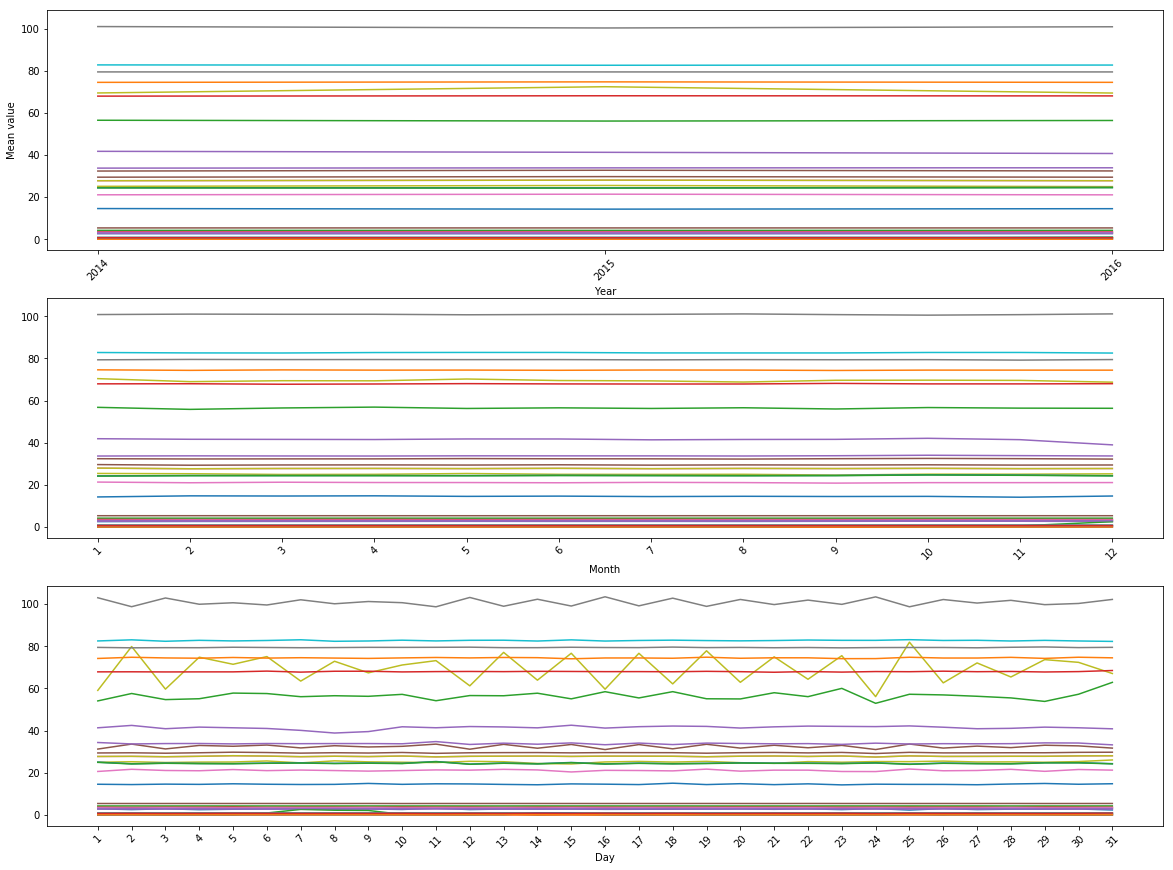

In [9]:
mean_yearly = train_data.drop(['Month', 'Day', 'Hour'], axis=1).groupby('Year').mean()
mean_monthly = train_data.drop(['Year','Day', 'Hour'], axis=1).groupby(['Month']).mean()
mean_daily = train_data.drop(['Month', 'Year', 'Hour'], axis=1).groupby('Day').mean()

labels_yearly = mean_yearly.index.values
labels_monthly = mean_monthly.index.values
labels_daily = mean_daily.index.values

f, ax = plt.subplots(nrows=3, ncols=1, figsize = (20, 15), sharey=True)

ax[0].plot(mean_yearly.values)
ax[0].set_xticks(range(len(labels_yearly)))
ax[0].set_xticklabels(labels_yearly, rotation=45)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Mean value")

ax[1].plot(mean_monthly.values)
ax[1].set_xticks(range(len(labels_monthly)))
ax[1].set_xticklabels(labels_monthly, rotation=45)
ax[1].set_xlabel("Month")

ax[2].plot(mean_daily.values)
ax[2].set_xticks(range(len(labels_daily)))
ax[2].set_xticklabels(labels_daily, rotation=45)
ax[2].set_xlabel("Day")

Text(0.5, 0, 'Day')

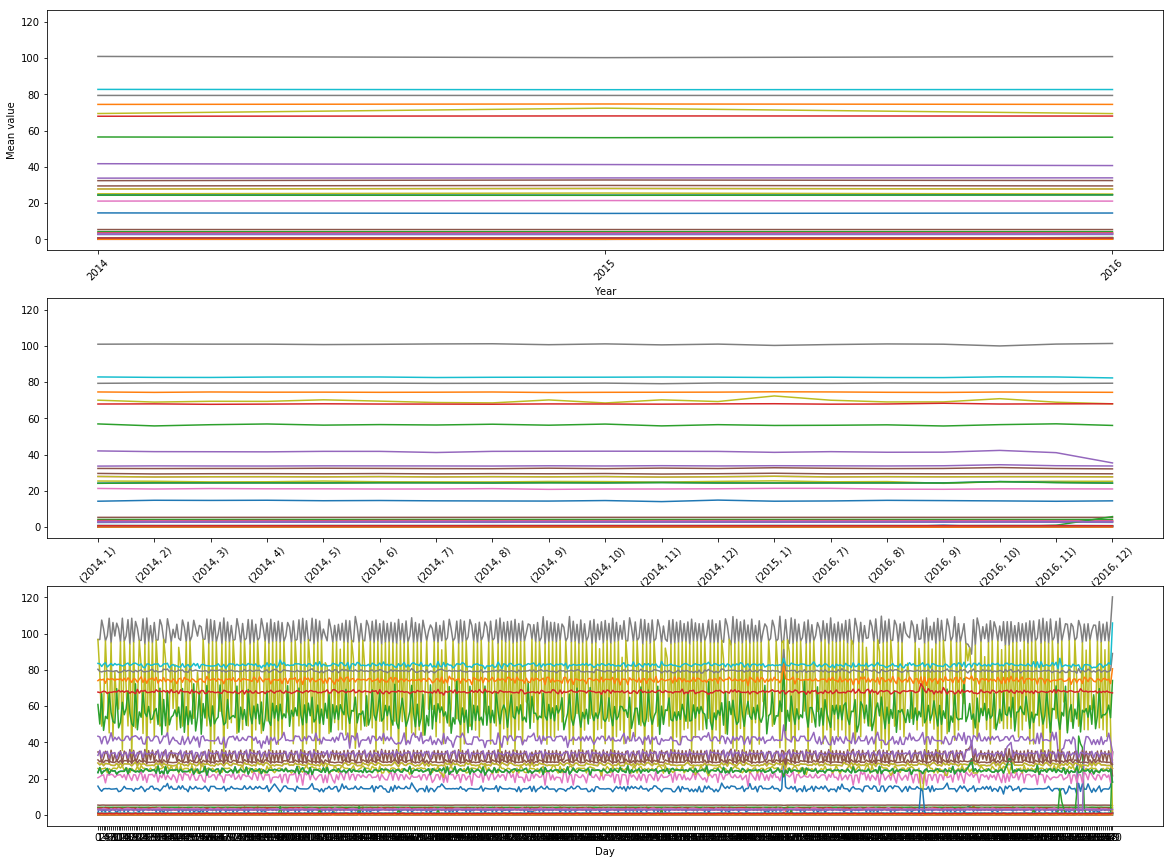

In [11]:
mean_yearly = train_data.drop(['Month', 'Day', 'Hour'], axis=1).groupby('Year').mean()
mean_monthly = train_data.drop(['Day', 'Hour'], axis=1).groupby(['Year', 'Month']).mean()
mean_daily = train_data.drop(['Hour'], axis=1).groupby(['Year','Month','Day']).mean()

labels_yearly = mean_yearly.index.values
labels_monthly = mean_monthly.index.values
labels_daily = mean_daily.index.values

f, ax = plt.subplots(nrows=3, ncols=1, figsize = (20, 15), sharey=True)

ax[0].plot(mean_yearly.values)
ax[0].set_xticks(range(len(labels_yearly)))
ax[0].set_xticklabels(labels_yearly, rotation=45)
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Mean value")

ax[1].plot(mean_monthly.values)
ax[1].set_xticks(range(len(labels_monthly)))
ax[1].set_xticklabels(labels_monthly, rotation=45)
ax[1].set_xlabel("Month")

ax[2].plot(mean_daily.values)
ax[2].set_xticks(range(len(labels_daily)))
# ax[2].set_xticklabels(labels_daily, rotation=45)
ax[2].set_xlabel("Day")


### ARMA

First use again the simple predictive model we used in the familiarization task, that is an ARMA (1,0) model.

In [15]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

signal = X1[:, 0]
model = ARMA(endog=signal, order=(1,0)).fit()

print("AIC: ", model.aic)
print("BIC: ", model.bic)
print("DW-test: ", sm.stats.durbin_watson(model.resid))

AIC:  -558.1004639865932
BIC:  -536.8662679885941
DW-test:  0.29607800631926867


Use auto-correlation (ACF) and partial auto-correlation (PACF) plots to guide for the grid search, in order to extract the optimal order of the fitted model.

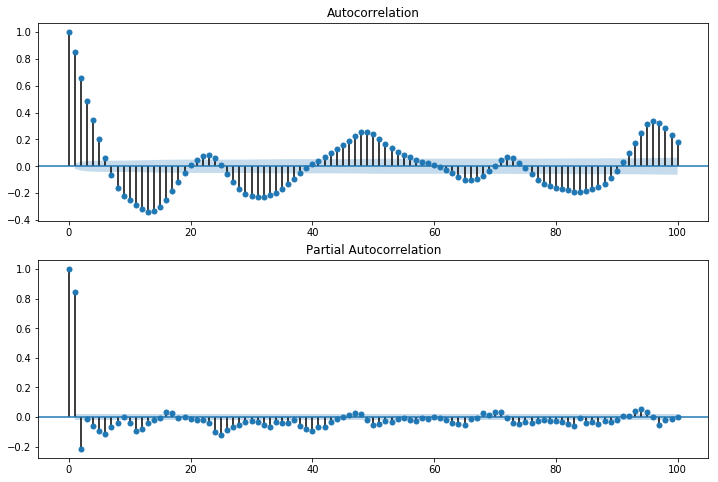

In [16]:
lags = 100

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(model.resid, lags=lags, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(model.resid, lags=lags, ax=ax[1])

#### Grid search for extracting optimal order for the ARMA model

In [3]:
# Determine optimal parameters
p = np.arange(1,6, dtype=int)
q = np.arange(1,6, dtype=int)

train_signal = X_scaled[:8761,0]
test_signal = X_scaled[8761:8800, 0]
train_labels = y[:8761]
test_labels = y[8761:8800]

opt_p, opt_q, AIC, _, _ = find_arma_order(train_signal, p, q)

print(AIC)
print(f"Best model fit with order ({p[opt_p]}, {q[opt_q]}), with AIC: {AIC[opt_p, opt_q]}")

KeyboardInterrupt: 

In [71]:
# Grid search can also be done this way; needs more iterations for convergence though
from pmdarima.arima import auto_arima

tt = auto_arima(y=train_signal, start_p=1,start_q=1,max_p=6,max_q=6, max_order=20,seasonal=False,return_valid_fits=True, maxiter=1000)
# tt

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


#### Fit and extract threshold

In [5]:
# summary of the fitted model
# opt_p, opt_q = 5,5
model = ARMA(endog=train_signal, order=(opt_p, opt_q))
model_fit = model.fit()
print(model_fit.summary())

# threshold for detecting anomalies on the test set
threshold = determine_threshold(train_signal, opt_p, opt_q, multiplier=1.5)
print("Threshold: ", threshold)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 8761
Model:                     ARMA(5, 5)   Log Likelihood                8417.682
Method:                       css-mle   S.D. of innovations              0.093
Date:                Sat, 25 May 2019   AIC                         -16811.365
Time:                        17:32:19   BIC                         -16726.428
Sample:                             0   HQIC                        -16782.424
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0071      0.012     -0.592      0.554      -0.031       0.016
ar.L1.y        3.7122      0.008    463.788      0.000       3.697       3.728
ar.L2.y       -6.0386        nan        nan        n

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


#### Predict and detect anomailes based on the set threshold

In [6]:
file = './arma.npy'
predictions, mfe, mae = predict(train_signal, test_signal, opt_p, opt_q, file)
print("MFE: ", mfe)
print("MAE: ", mae)

alarm_ind = extract_alarm_indices(test_signal, predictions, threshold)
print("Number of anomalies: ", np.sum(alarm_ind))

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likel

MFE:  -0.009840539839084754
MAE:  0.156148105112931
Number of anomalies:  0


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


#### Plot predictions vs actual values

(39, 1)


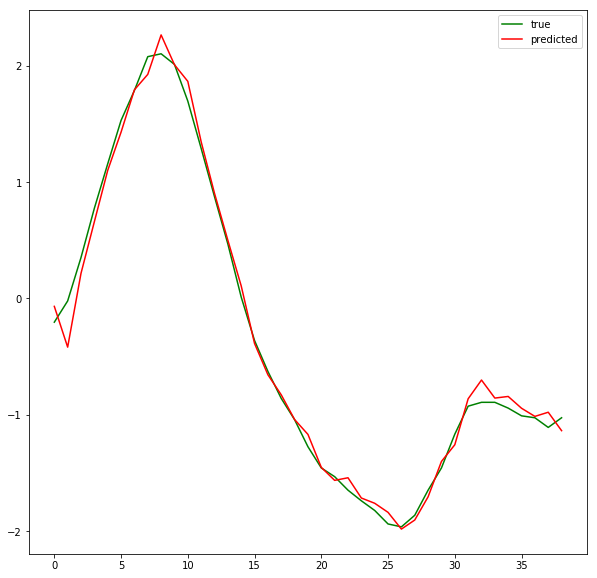

In [10]:
print(predictions.shape)
plt.figure(figsize=(10,10))
plt.plot(X_scaled[8761:8800, 0], color='g', label='true')
plt.plot(predictions, color='r', label='predicted')
plt.legend()

In [57]:
def detect_num_attacks(test_labels):
    na=0
    pos=test_labels[0]
    for y in test_labels[1:]:
        if y==1:
            if pos==0:
                pos=1
        else:
            if pos==1:
                pos=0
                na=na+1
    return na

def compute_sttd(test_labels, predicted_labels):
    num_attacks = detect_num_attacks(test_labels)
    total_auc = np.sum(test_labels==1)
    intersect =  np.logical_and(test_labels==1, predicted_labels==1)
    intersect_auc = np.sum(intersect)
    diff = total_auc - intersect_auc
    sttd = 1 - num_attacks * diff
    return sttd

def estimate_confusion_matrix(test_labels, alarm_ind):
    TP = np.sum(np.isin(alarm_ind, test_labels[test_labels==1]))
    FP = np.sum(TP[TP==0])
    FN = np.sum(np.isin(test_labels[test_labels==1], alarm_ind, invert=True))
    TN = np.sum(np.isin(test_labels[test_labels==0], alarm_ind, invert=True))
    
    cm = np.array([[TP, FP][FN, TN]])
    return cm

def compute_scm(cm):
    TPR = cm[0,0]/(cm[0,0] + cm[1,0])
    TNR = cm[1,1]/(cm[0,1] + cm[1,1])
    
    scm = (TPR + TNR)/2
    
def compute_s(test_labels, predicted_labels, cm, gamma):
    sttd = compute_sttd(test_labels, predicted_labels)
    scm = compute_scm(cm)
    s = gamma*sttd + (1-gamma)*scm
    return s

In [55]:
compute_sttd(tt, tt)

1

In [53]:
predictions

array([-0.08495739, -0.43198479,  0.21051388,  0.66964862,  1.10817056,
        1.4476477 ,  1.80782376,  1.92496318,  2.24658672,  1.99266455,
        1.85726415,  1.3589292 ,  0.91261041,  0.49909786,  0.09252523,
       -0.40329462, -0.65906559, -0.81633202, -1.02640028, -1.16083929,
       -1.45231551, -1.57327819, -1.55067106, -1.72003653, -1.75759659,
       -1.82783033, -1.97791409, -1.91089142, -1.71739551, -1.41359206,
       -1.25751248, -0.85111887, -0.685586  , -0.85356117, -0.8514461 ,
       -0.95893503, -1.03221425, -0.98426672, -1.12793556])